# Machine Learning

In [1]:
import os # version: 3.9.19
import sys # version: 3.9.19
import pandas as pd # version: 2.2.2
import qiime2 as q2 # version: 2024.5.0
from qiime2 import Visualization
import matplotlib.pyplot as plt # version: 3.8.4
%matplotlib inline

# Define the data directory
data_dir = './data'

In [ ]:
import os

In [48]:
!pwd

/home/jovyan/FunGut2/full-pipeline


In [ ]:
!qiime sample-classifier classify-samples --help

## Objective

In our data set we have some samples where certain features/columns in meta data are not provided. For example do we not know for some samples whether they are allergic to gluten or not. But we do not want to miss out on this samples. So it would be awsome if we can predict these missing values based on the patterns we see over all our data. Therefore, we want to use machine learning to predict the missing values based on the feature table (microbiome composition). If this works well (the accuracy of our test set is high) we can predict the not provided values which is great for other analysis steps where we need this information. And second, if it works well we know that the microbiome composition alone contains the information about the diesease state of a person.

## Filter Feature Table

First we have to filter the 'Not provided' values. Because we only want to train on the samples that do not miss this information. We focus on the symptom state for 'gluten', 'IBD' and the 'diet type'. Therefore, we create for each feature a filtered feature table, where we filter out the 'Not provided' values its own column.

In [8]:
!qiime feature-table filter-samples \
    --i-table ./data/feature_tables_dada/filtered-feature-table.qza \
    --m-metadata-file $data_dir/metadata/fungut_metadata_processed.tsv \
    --p-where "[gluten_symptoms] != 'Not provided'" \
    --o-filtered-table ./data/feature_tables_dada/machine_learning_gluten_table.qza

Saved FeatureTable[Frequency] to: ./data/feature_tables_dada/machine_learning_gluten_table.qza


In [17]:
!qiime feature-table filter-samples \
    --i-table ./data/feature_tables_dada/filtered-feature-table.qza \
    --m-metadata-file $data_dir/metadata/fungut_metadata_processed.tsv \
    --p-where "[ibd_symptoms] != 'Not provided'" \
    --o-filtered-table ./data/feature_tables_dada/machine_learning_ibd_table.qza

Saved FeatureTable[Frequency] to: ./data/feature_tables_dada/machine_learning_ibd_table.qza


In [18]:
!qiime feature-table filter-samples \
    --i-table ./data/feature_tables_dada/filtered-feature-table.qza \
    --m-metadata-file $data_dir/metadata/fungut_metadata_processed.tsv \
    --p-where "[diet_type_sample] != 'Not provided'" \
    --o-filtered-table ./data/feature_tables_dada/machine_learning_diet_table.qza

Saved FeatureTable[Frequency] to: ./data/feature_tables_dada/machine_learning_diet_table.qza


In the next block we also prepare a feature table which only contains information where the samples are USA, Australe or United Kingdom. This is done to see if we can predict well this groups, since they are about equal in size and had significantly enriched taxas in the differential abundance analysis.

In [43]:
!qiime feature-table filter-samples \
    --i-table ./data/feature_tables_dada/filtered-feature-table.qza \
    --m-metadata-file $data_dir/metadata/fungut_metadata_processed.tsv \
    --p-where "[country_sample] != 'Not provided' and ([country_sample] = 'USA' or [country_sample] = 'United Kingdom' or [country_sample] = 'Australia')" \
    --o-filtered-table ./data/feature_tables_dada/machine_learning_country_table.qza

Saved FeatureTable[Frequency] to: ./data/feature_tables_dada/machine_learning_country_table.qza


## Classifying with Qiime2 classifier function  
First, we try to use a pre-built function of Qiime2. This function takes a feature table and tries to learn to classify each sample into a category given by the meta data. Here we show the implementation for predicting the symptom state of 'gluten'.  
As we can see in the visualisation the predicting model is pretty bad. The accuracy is high (about 80%) but this is not due to the fact that the model can distinguish well. It is the opposite, the model just always predicts the most common category, which is in our example 'no_symptoms'. The problem is that we have very unequal group sizes. The 'no_symptoms' group is much bigger than the other.  
The same promlems appear for 'IBD' and 'diet type'. The distribution of the groups is very uneven and the model just always predicts the overrepresented group.

In [45]:
! rm -r ./data/machine_learning/x

rm: cannot remove './data/machine_learning': No such file or directory


In [55]:
!qiime sample-classifier classify-samples \
    --i-table $data_dir/feature_tables_dada/machine_learning_gluten_table.qza \
    --m-metadata-file $data_dir/metadata/fungut_metadata_processed.tsv \
    --m-metadata-column gluten_symptoms \
    --p-random-state 42 \
    --p-parameter-tuning \
    --p-estimator GradientBoostingClassifier \
    --output-dir ./data/machine_learning/gluten

Saved SampleEstimator[Classifier] to: ./data/machine_learning/gluten/sample_estimator.qza
Saved FeatureData[Importance] to: ./data/machine_learning/gluten/feature_importance.qza
Saved SampleData[ClassifierPredictions] to: ./data/machine_learning/gluten/predictions.qza
Saved Visualization to: ./data/machine_learning/gluten/model_summary.qzv
Saved Visualization to: ./data/machine_learning/gluten/accuracy_results.qzv
Saved SampleData[Probabilities] to: ./data/machine_learning/gluten/probabilities.qza
Saved Visualization to: ./data/machine_learning/gluten/heatmap.qzv
Saved SampleData[TrueTargets] to: ./data/machine_learning/gluten/training_targets.qza
Saved SampleData[TrueTargets] to: ./data/machine_learning/gluten/test_targets.qza


In [57]:
Visualization.load('./data/machine_learning/country/accuracy_results.qzv')

<visualization: Visualization uuid: f99ddd28-f4e3-4e48-9d22-6138382d1bd1>

# Self made Classifier
We saw that we were not able to use the Qiime2 function (sample-classifier classify-samples) to predict accurately. Therefore, we tried to build our own machine learning classifier. This gives us more flexibility on the model. We can for example tweak the loss function or the preprocessing of the feature table (normalizing). And we can also try to over sample the minorty groups with Synthetic Minority Over-sampling Technique (SMOTE).

First we install some packages (imblearn and xgboost)

In [ ]:
!pip install imblearn

In [ ]:
!pip install xgboost

Here we have to make sure that our seaborn version is 0.13.2! If not we get some wrong plots later (missing values)

In [ ]:
!pip show seaborn

So: If the version is older than 13.2 run the following command before loading the module

In [ ]:
!pip install --upgrade seaborn

In [2]:
import os
import sys
import seaborn as sns
import pandas as pd
import numpy as np
import qiime2 as q2
from qiime2 import Visualization
import matplotlib.pyplot as plt
%matplotlib inline

from biom import load_table
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import SparsePCA

# Define the data directory
data_dir = './data'

### export feature table and load as data frame
Here, we export our feature table to be able to load it as a data frame.

In [ ]:
!qiime tools export \
        --input-path $data_dir/feature_tables_dada/filtered-feature-table.qza \
        --output-path $data_dir/feature_tables_dada/exported-feature-table

In [3]:
biom_table = load_table(f'{data_dir}/feature_tables_dada/exported-feature-table/feature-table.biom')
# Convert the biom table to a pandas DataFrame
feature_table = biom_table.to_dataframe()

In [4]:
meta = pd.read_csv(f'{data_dir}/metadata/fungut_metadata_processed.tsv', sep='\t')

### Prepare data (X=features and y=label)
Then we load the data into numpy and perform a log-transformation and make a transform the string lables into binary format

In [5]:
X = feature_table.T  
y = meta.gluten_symptoms 

#filter 'not_provided'
y = y[y != 'Not provided']
X = X.iloc[y.index]

In [6]:
# scale with log-transformation
X = np.log1p(X) 
# turn into numpy array
X = X.to_numpy()
y = y.to_numpy()

In [7]:
# Here, we tried to use PCA to reduce the dimension of the feature table, but this did not improve the results...
#spca = SparsePCA(n_components=100, random_state=42)
#X = spca.fit_transform(X)

# Encode the target labels into numeric values
le = LabelEncoder()
y = le.fit_transform(y)  # Converts strings to integers

### Model computation

### testing

Accuracy: 0.5517241379310345
Ratio (predict most likely): 0.6956521739130435
Accuracy: 0.5517241379310345
Ratio (predict most likely): 0.6956521739130435
Accuracy: 0.6206896551724138
Ratio (predict most likely): 0.782608695652174
Accuracy: 0.6896551724137931
Ratio (predict most likely): 0.9090909090909092
Accuracy: 0.75
Ratio (predict most likely): 0.9545454545454546


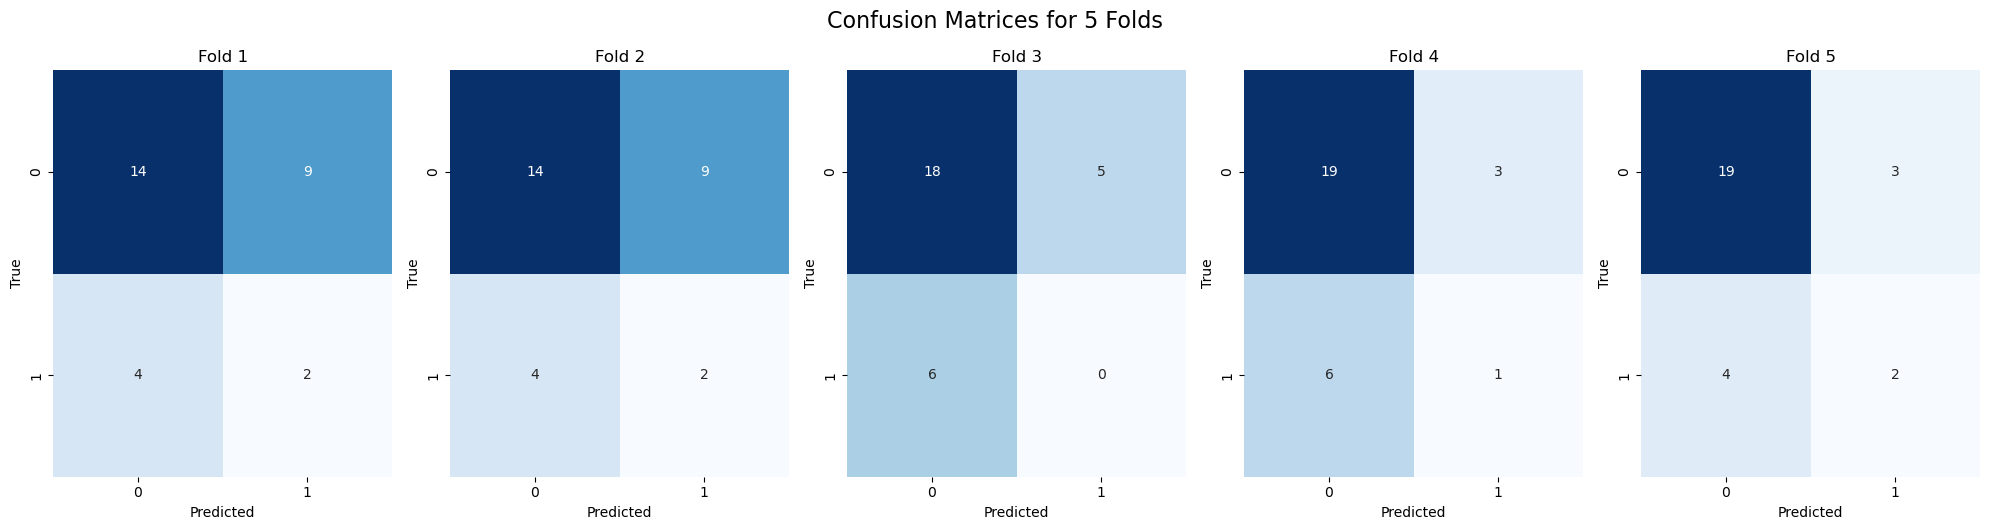

In [18]:
# Stratified K-Fold Cross-validation (ensures each fold has the same class distribution)
kf = StratifiedKFold(n_splits=5)

# Initialize the figure for subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    #calculate scale to adjust weight of underreprestend group
    scale_pos_weight =  (len(y_train) - sum(y_train)) / sum(y_train)
    
    # Apply SMOTE to the training set --> create new datapoints of minority group (disease)
    smote = SMOTE()
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    #model = RandomForestClassifier(class_weight='balanced', random_state=42)
    #model.fit(X_train, y_train)

    model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight,  
                              eval_metric='logloss',
                              objective='binary:logistic')
    model.fit(X_train_smote, y_train_smote)

    #model = LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)
    #model.fit(X_train_smote, y_train_smote)
    
    
    
    # Evaluate model
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Ratio (predict most likely): {accuracy_score(y_test, y_pred)/((len(y_test) - sum(y_test))/len(y_test))}')
    
    # Get class distribution using numpy.unique()
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    # Print class distributions
    #print(f"True class distribution: {dict(zip(unique_test, counts_test))}")
    #print(f"Predicted class distribution: {dict(zip(unique_pred, counts_pred))}")
    
    cm = confusion_matrix(y_test, y_pred)
    
    ax = axes[fold - 1]  # Select subplot
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=np.unique(y), yticklabels=np.unique(y),
                cbar=False, ax=ax)
    ax.set_title(f'Fold {fold}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    

# Adjust layout
plt.tight_layout()
plt.suptitle('Confusion Matrices for 5 Folds', fontsize=16, y=1.05)
plt.show()

### final model
We played around with a lot of different estimators, normalizing steps, oversampling etc. In the end we used the following model:

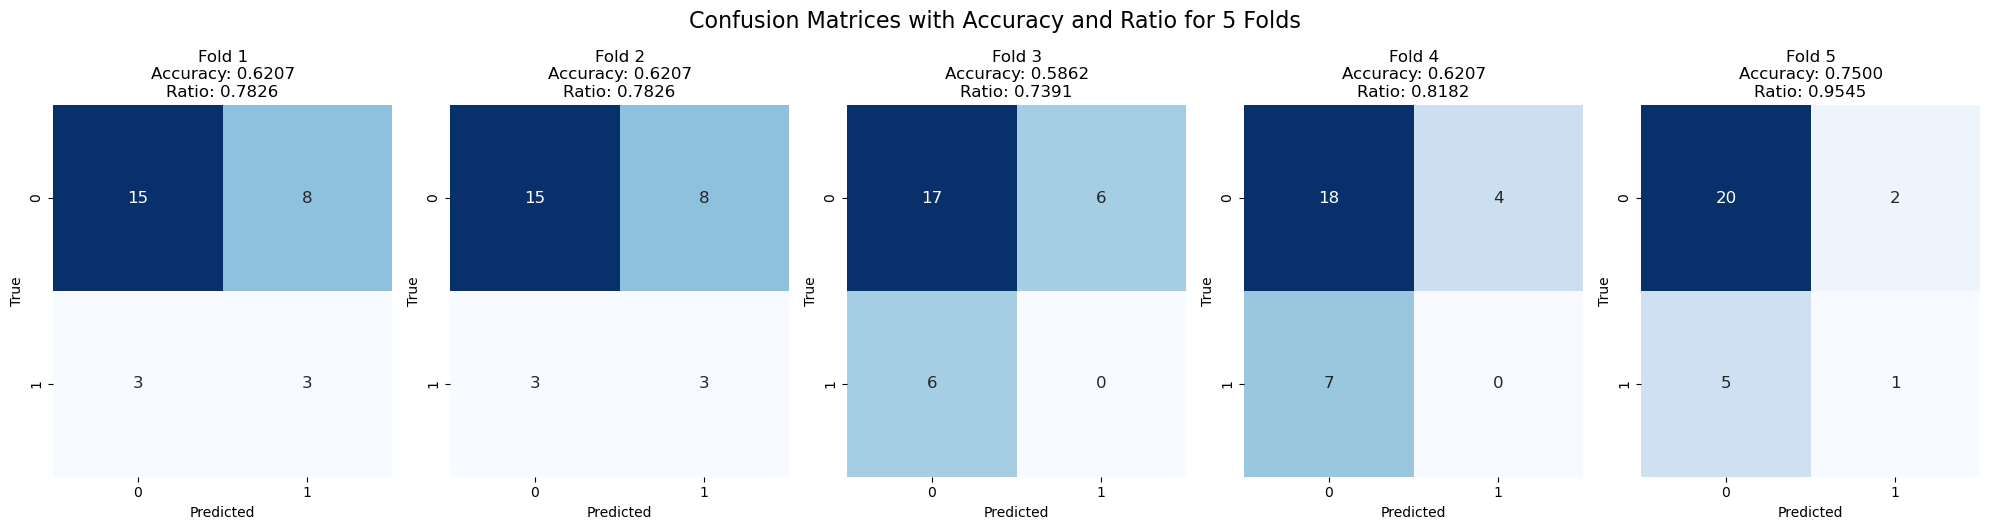

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# Stratified K-Fold Cross-validation
kf = StratifiedKFold(n_splits=5)

# Initialize the figure for subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

# Loop through the folds
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Calculate scale_pos_weight
    scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
    
    # Apply SMOTE to the training set
    smote = SMOTE()
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Train the model using XGBoost
    model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight,  
                              eval_metric='logloss',
                              objective='binary:logistic')
    model.fit(X_train_smote, y_train_smote)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    ratio = accuracy / ((len(y_test) - sum(y_test)) / len(y_test))
    #print(f'Fold {fold} Accuracy: {accuracy:.4f}')
    #print(f'Fold {fold} Ratio: {ratio:.4f}')
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix in the corresponding subplot
    ax = axes[fold - 1]  # Select subplot
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=np.unique(y), yticklabels=np.unique(y),
                cbar=False, ax=ax, annot_kws={"size": 12})
    
    # Add titles and text with accuracy and ratio
    ax.set_title(f'Fold {fold}\nAccuracy: {accuracy:.4f}\nRatio: {ratio:.4f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

# Adjust layout
plt.tight_layout()
plt.suptitle('Confusion Matrices with Accuracy and Ratio for 5 Folds', fontsize=16, y=1.05)
plt.show()


### Result
We managed to build a model, so that it not only predicts the overrepresented group. This was done by scaling the weigths of the minority group and using SMOTE. From the confusion matrices above we can see that we are sometimes able to correctly predict the disease (bottom right of confusion matrix, 1=symptoms (minority group). But overall our accuracy is not very mind blowing. The Ratio (compared to base model of always predicting the overrepresented group) is never higher than 1.  
We think that it might could be that there is no clear pattern/difference to find. Because in the differential abundance analysis we also did not find any significant enriched or depleted taxonomies.

### Try to predict country (USA, UK and Australia)
Here we try to predict the country based on the feature table. We are not very much interested in predicting the country, but we want to see whether we can get some more accurate predictions, because we found significant enriched/depleted taxonomies between these groups. Therefore, the classifier will also perfom better. But we only considered the three countries 'United Kingdom', 'USA' and 'Australia'. This will probably also increase the performance because these 3 groups are about equal in size.

In [23]:
X = feature_table.T  
y = meta.country_sample

#filter 'not_provided'
y = y[y.isin(['United Kingdom', 'USA', 'Australia'])]
X = X.iloc[y.index]
# scale with log-transformation
X = np.log1p(X) 
# turn into numpy array
X = X.to_numpy()
y = y.to_numpy()
le = LabelEncoder()
y= le.fit_transform(y)  # Converts strings to integers

In [24]:
print(y)

counts = np.bincount(y)
most_common_count = counts.max()
accuracy_null_model = most_common_count / len(y)
print('Accuracy of predicting overrepresented =', accuracy_null_model)

[1 1 1 2 2 2 2 2 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Accuracy of predicting overrepresented = 0.381294964028777


Fold 1 Accuracy: 0.3571
Fold 1 Ratio: 1.0714
Fold 2 Accuracy: 0.4286
Fold 2 Ratio: 1.2857
Fold 3 Accuracy: 0.5357
Fold 3 Ratio: 1.6071
Fold 4 Accuracy: 0.4286
Fold 4 Ratio: 1.2857
Fold 5 Accuracy: 0.4815
Fold 5 Ratio: 1.4444


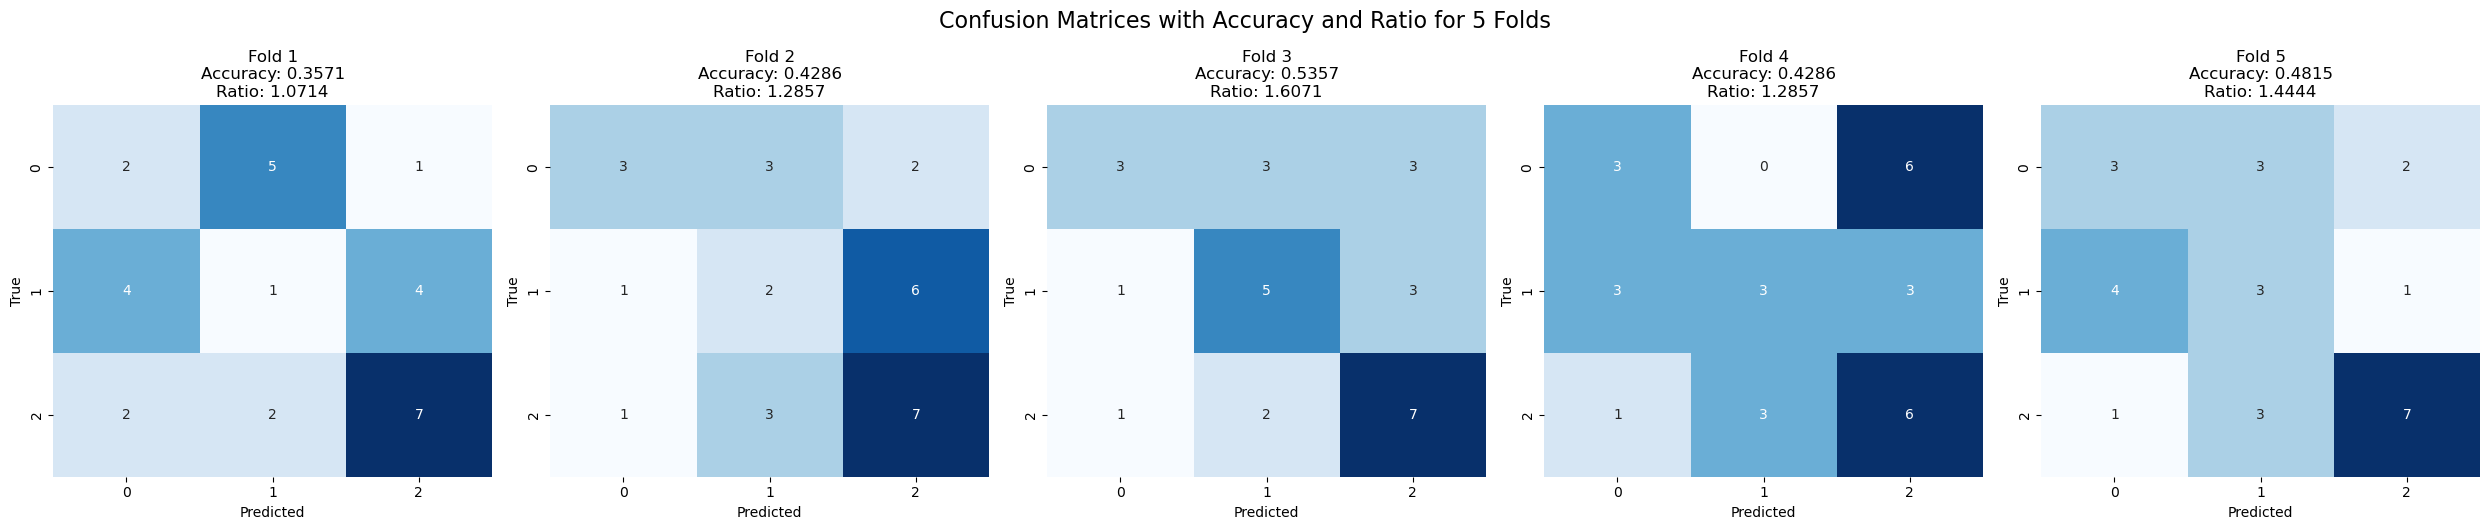

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# Stratified K-Fold Cross-validation
kf = StratifiedKFold(n_splits=5)

# Initialize a figure with 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))  # 1 row, 5 columns

accuracy_null_model = 1 / len(np.unique(y))  # Baseline accuracy for ratio calculation

# Loop through the folds
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train the model
    model = xgb.XGBClassifier(eval_metric='mlogloss', objective='multi:softmax')
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    ratio = accuracy / accuracy_null_model
    
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")
    print(f"Fold {fold} Ratio: {ratio:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix in the corresponding subplot
    ax = axes[fold - 1]  # Select subplot
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=np.unique(y), yticklabels=np.unique(y),
                cbar=False, ax=ax, annot_kws={"size": 10})
    
    # Add titles and subtitle information
    ax.set_title(f'Fold {fold}\nAccuracy: {accuracy:.4f}\nRatio: {ratio:.4f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

# Adjust layout for clarity
plt.tight_layout()
plt.suptitle('Confusion Matrices with Accuracy and Ratio for 5 Folds', fontsize=16, y=1.05)
plt.show()


### Result  
We managed to increase the Ratio to higher than 1. But the accuracy is still not that well. And our self built model was not better than the results of the prebuilt Qiime2 function. This means that we probalby would have potential to improve our model.

Overall, we think using machine learning to predict missing values could work out if we had a much larger data set. Then we could better handle the unequal group sizes. And with further optimization of the model we would probably be able get some useful predictions. But we cannot confirm this since our data set is very small for a machine learning task and we are not experts in machine learning :)